In [0]:
##mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import csv

In [0]:
base_path = '/content/drive/My Drive/DL_exp/'

In [0]:
### visualize data points 

# Input: (n,3) numpy array for data points and (n,1) numpy array for labels (values: 0 or 1)
def plot_3D_data(points,labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[np.where(labels == 1)[0],0],points[np.where(labels == 1)[0],1],points[np.where(labels == 1)[0],2])
    ax.scatter(points[np.where(labels == 0)[0],0],points[np.where(labels == 0)[0],1],points[np.where(labels == 0)[0],2])
    plt.show()

# Input: (n,2) numpy array for data points and (n,1) numpy array for labels (values: 0 or 1)
def plot_2D_data(points,labels):
    plt.scatter(points[np.where(labels == 1)[0],0],points[np.where(labels == 1)[0],1])
    plt.scatter(points[np.where(labels == 0)[0],0],points[np.where(labels == 0)[0],1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

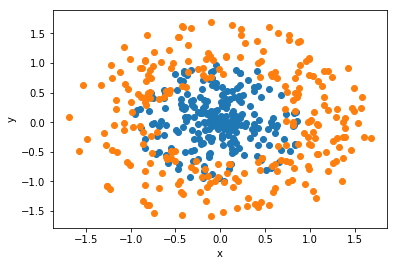

In [0]:
## generate sphere shell binary data by computing n dimensional Cartesian coordinates using radial coordinate r, and n − 1 angular coordinates
# Input : num of samples, points dimension , radius of sphere, radius of shell, thickness of shell
# Output : returns (num of samples,points dimension) numpy array of data points and (num of samples,1) numpy array of labels (values: 0 or 1)
def data_sphere_shell_coordinates(num_samples,points_dim,radius_of_sphere, radius_of_shell, thickness_of_shell):

    points = np.zeros([num_samples, points_dim])
    labels = np.zeros([num_samples,1]).astype(int)
    
    # Generate positive points inside the circle.
    for i in range(num_samples // 2):
        r = random.uniform(0, radius_of_sphere)
        angle = np.zeros(points_dim-1)
        for j in range(points_dim-2):
            angle[j] = random.uniform(0, np.pi)
        angle[points_dim-2] = random.uniform(0, 2 * np.pi)
        
        x = np.zeros(points_dim)
        for j in range(points_dim-1):
            x[j] = r * np.cos(angle[j])
            r = r * np.sin(angle[j])
        x[points_dim-1] = r
        labels[i] = 1
        points[i] = x

    # Generate negative points outside the circle.
    for i in range(num_samples // 2, num_samples):
        r = random.uniform(radius_of_shell-(thickness_of_shell/2), radius_of_shell+(thickness_of_shell/2))
        angle = np.zeros(points_dim-1)
        for j in range(points_dim-2):
            angle[j] = random.uniform(0, np.pi)
        angle[points_dim-2] = random.uniform(0, 2 * np.pi)
        
        x = np.zeros(points_dim)
        for j in range(points_dim-1):
            x[j] = r * np.cos(angle[j])
            r = r * np.sin(angle[j])
        x[points_dim-1] = r
        labels[i] = 0
        points[i] = x
        
    return points, labels
  
  
points_dim = 2
num_samples = 500
radius_of_sphere = 1
radius_of_shell = 1.2
thickness_of_shell = 1
points, labels = data_sphere_shell_coordinates(num_samples,points_dim,radius_of_sphere, radius_of_shell, thickness_of_shell)

plot_2D_data(points,labels)

# csv file path to store generated data
csv_path = base_path+'sphere_shell_data_version1/train_sp'+ str(radius_of_sphere) + '_sh'+ str(radius_of_shell) + '_t' + str(thickness_of_shell)+ '_' + str(points_dim) + 'dim.csv'     
with open(csv_path, 'w') as writeFile:
    writer = csv.writer(writeFile)
    header = ["c"+str(i) for i in range(points_dim)]
    header.append("label")
    writer.writerow(header)
    writer.writerows(np.hstack((points,labels)))

In [0]:
## function returns defined number of samples with label
# Input : (n,points_dim) numpy array, number of samples, points dimension, radius of sphere, radius of shell, thickness of shell
# Output : returns (num of samples,points dimension+1) numpy array of data points where last column is for labels (values: 0 or 1)
# n != num of samples
def get_samples_with_label(gendata,num_samples,points_dim,radius_of_sphere, radius_of_shell, thickness_of_shell):
  positive_count = 0
  negative_count = 0
  data = np.zeros((num_samples,points_dim+1))
  for p in gendata:
    
    if positive_count>=(num_samples/2) and negative_count>=(num_samples/2):
      return data
    
    value = np.sqrt(np.sum(np.square(p)))
    
    #if data is overlapping
    if radius_of_shell-(thickness_of_shell/2)<=radius_of_sphere:
      if positive_count<(num_samples/2) and value < radius_of_shell-(thickness_of_shell/2):
        data[positive_count+negative_count,:-1] = p
        data[positive_count+negative_count,-1] = 1
        positive_count+=1
      elif negative_count<(num_samples/2) and value > radius_of_sphere and value <= radius_of_shell+(thickness_of_shell/2):
        data[positive_count+negative_count,:-1] = p
        data[positive_count+negative_count,-1] = 0
        negative_count+=1
      elif value <= radius_of_sphere and value >= radius_of_shell-(thickness_of_shell/2):
        prob = random.uniform(0, 1)
        if prob<=0.5 and negative_count<(num_samples/2):
          data[positive_count+negative_count,:-1] = p
          data[positive_count+negative_count,-1] = 0
          negative_count+=1
        elif prob>0.5 and positive_count<(num_samples/2):
          data[positive_count+negative_count,:-1] = p
          data[positive_count+negative_count,-1] = 1
          positive_count+=1
    
    #if data is not overlapping
    else:
      if positive_count<(num_samples/2) and value <= radius_of_sphere:
        data[positive_count+negative_count,:-1] = p
        data[positive_count+negative_count,-1] = 1
        positive_count+=1
      elif negative_count<(num_samples/2) and value >= radius_of_shell-(thickness_of_shell/2) and value <= radius_of_shell+(thickness_of_shell/2):
        data[positive_count+negative_count,:-1] = p
        data[positive_count+negative_count,-1] = 0
        negative_count+=1
  print(negative_count,positive_count)
  
  return data

In [0]:
## generate sphere shell binary data from n-dimensional gaussian         
points_dim = 2
num_samples = 500
radius_of_sphere = 1
radius_of_shell = 2
thickness_of_shell = 1

mean = np.zeros(points_dim)
cov = 1.3*np.identity(points_dim)
gaussian_data = np.random.multivariate_normal(mean, cov, 10000)

data = get_samples_with_label(gaussian_data,num_samples,points_dim,radius_of_sphere, radius_of_shell, thickness_of_shell)

# plot_2D_data(data[:,:-1],data[:,-1])

#path to csv file to store generated data
csv_path = base_path+'sphere_shell_data_version2_using_gaussian/train_sp'+ str(radius_of_sphere) + '_sh'+ str(radius_of_shell) + '_t' + str(thickness_of_shell)+ '_' + str(points_dim) + 'dim.csv'     
with open(csv_path, 'w') as writeFile:
    writer = csv.writer(writeFile)
    header = ["c"+str(i) for i in range(points_dim)]
    header.append("label")
    writer.writerow(header)
    writer.writerows(data)

<BarContainer object of 5 artists>

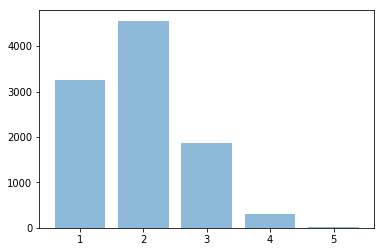

In [0]:
### Bar graph of number of points by radius in the data
data = gaussian_data

x = [1,2,3,4,5]    #radius
y = [0,0,0,0,0]    #point count
for p in data:
    value = np.sqrt(np.sum(np.square(p)))
    if value<=x[0]:
      y[0]+=1
    elif value<=x[1]:
      y[1]+=1
    elif value<=x[2]:
      y[2]+=1
    elif value<=x[3]:
      y[3]+=1
    elif value<=x[4]:
      y[4]+=1
    
plt.bar(x, y, align='center', alpha=0.5)

In [0]:
#calculate bayes risk for overlapping data
points_dim = 64
radius_of_sphere = 1
radius_of_shell = 1.2
thickness_of_shell = 1

overlapping_data_volume = (np.pi**(points_dim/2))/(math.gamma((points_dim/2)+1))*((radius_of_sphere**points_dim) - ((radius_of_shell-(thickness_of_shell/2))**points_dim))
neg_data_volume = (np.pi**(points_dim/2))/(math.gamma((points_dim/2)+1))*(((radius_of_shell+(thickness_of_shell/2))**points_dim) - ((radius_of_shell-(thickness_of_shell/2))**points_dim))
pos_data_volume = (np.pi**(points_dim/2))/(math.gamma((points_dim/2)+1))*(radius_of_sphere**points_dim)
neg_data_risk = 0.5*overlapping_data_volume/neg_data_volume
pos_data_risk = 0.5*overlapping_data_volume/pos_data_volume
bayes_risk = min(neg_data_risk,pos_data_risk)
bayes_risk

8.917416184748933e-16

In [0]:
## generate sphere shell binary data by a direction chosen uniformly at random 
## and a norm drawn uniformly at random from the interval [0,radius_of_shell+(thickness_of_shell/2)] 
points_dim = 2
num_samples = 500
radius_of_sphere = 1
radius_of_shell = 1.5
thickness_of_shell = 1

a = np.random.uniform(-1.0, 1.0, (2000,points_dim))
norm = np.sqrt(np.sum(np.square(a),axis=1))
multiplier = np.random.uniform(0, radius_of_shell+(thickness_of_shell/2), (2000,1))
gendata = (a/norm[:,None])*multiplier

data = get_samples_with_label(gendata,num_samples,points_dim,radius_of_sphere, radius_of_shell, thickness_of_shell)

#path to csv file to store generated data
csv_path = base_path+'sphere_shell_data_version3_using_uniform/train_sp'+ str(radius_of_sphere) + '_sh'+ str(radius_of_shell) + '_t' + str(thickness_of_shell)+ '_' + str(points_dim) + 'dim.csv'     
with open(csv_path, 'w') as writeFile:
    writer = csv.writer(writeFile)
    header = ["c"+str(i) for i in range(points_dim)]
    header.append("label")
    writer.writerow(header)
    writer.writerows(data)